In [1]:
# !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
# !bash install_colab.sh

In [2]:
from icevision.all import *

# Loading dataset

In [3]:
dataset_dir = './coco-2017-set2'

annot = dataset_dir + '/train/labels.json'
img_dir = dataset_dir  + '/train/data'

parser = parsers.COCOBBoxParser(annotations_filepath=annot, img_dir=img_dir)
train_records, valid_records = parser.parse()

image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)


INFO     - Autofixing records | icevision.parsers.parser:parse:136


# Making model

In [4]:
# Just change the value of selection to try another model

selection = 2 # !!! Zero will lead to error in signle image inference  


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model = model_type.model(backbone=backbone(pretrained=True),num_classes=len(parser.class_map), **extra_args)


# Making dataloader

In [5]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

# Training the model

In [6]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learner1 = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
learner1.fine_tune(20, 1e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.062842,0.760346,0.198770,00:26


epoch,train_loss,valid_loss,COCOMetric,time
0,1.051618,0.800488,0.191371,00:30
1,1.005917,0.803631,0.182170,00:30
2,0.975309,0.777121,0.188689,00:30
3,0.963722,0.769977,0.190238,00:30
4,0.952319,0.786734,0.181439,00:30
5,0.915888,0.738474,0.204414,00:30
6,0.885081,0.729338,0.203805,00:31
7,0.890472,0.717900,0.209429,00:31
8,0.871289,0.721993,0.206784,00:31
9,0.858961,0.743597,0.206321,00:31


# Saving model parameters

In [12]:
PATH = 'model2.mm'
torch.save(model.state_dict(), PATH)

# Select image from a folder

In [18]:
# load all images from folder for preview
dataset_dir = './coco-2017-set1'
import cv2 
import os 
import glob 
img_dir = "" # Enter Directory of all images  
data_path = dataset_dir + '/train/data' + '/*'

files = glob.glob(data_path) 
imgs = [] 
imgs_path = []
for f1 in files: 
    img = PIL.Image.open(f1)
    imgs.append(img) 
    imgs_path.append(f1)


./coco-2017-set1/train/data/000000054411.jpg


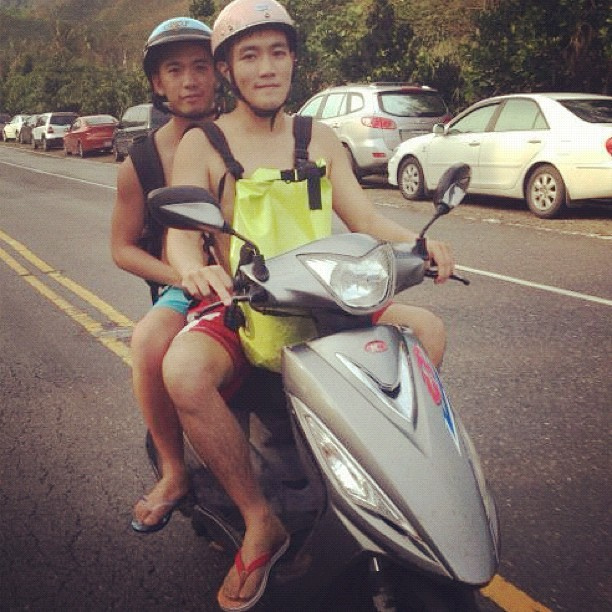

In [19]:
# preview one image
image_id = 92
print(imgs_path[image_id])
img = imgs[image_id]
img


# Select image from file

In [10]:
# from PIL import Image
# import requests

# url = r'https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D8hEXptpqTVo&psig=AOvVaw3pmZ4qiMz1hwmu0ewrg7eZ&ust=1626581441304000&source=images&cd=vfe&ved=2ahUKEwiH8KmZnunxAhWngGMGHYorB38QjRx6BAgAEA8'
# img = Image.open(requests.get(url, stream=True).raw)    
# img  

# img = Image.open('./coco-2017-set1/train/data/000000001799.jpg')
# img

# Prediction

[3, 3, 1, 4, 3]
[<BBox (xmin:244.34100341796875, ymin:54.873138427734375, xmax:384.0, ymax:136.54063415527344)>, <BBox (xmin:181.05191040039062, ymin:47.965633392333984, xmax:282.4595947265625, ymax:116.19416809082031)>, <BBox (xmin:72.66947937011719, ymin:0.0, xmax:207.99195861816406, ymax:364.0910949707031)>, <BBox (xmin:106.86972045898438, ymin:81.04193115234375, xmax:314.520751953125, ymax:380.103271484375)>, <BBox (xmin:38.70600891113281, ymin:71.52676391601562, xmax:75.642578125, ymax:100.12298583984375)>]
[    0.76006     0.72932     0.57036     0.53859     0.52247]


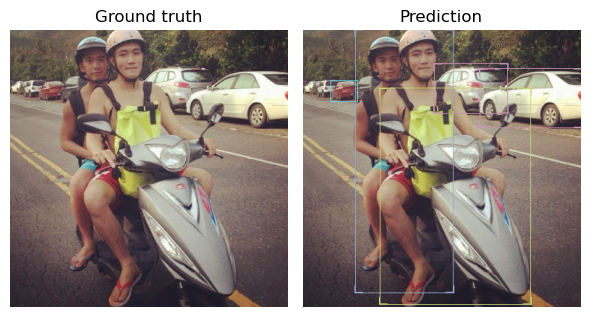

In [20]:
# Inference. Shows scores, labels and bounding boxes.
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])
infer_ds = Dataset.from_images([img], infer_tfms)

preds = model_type.predict(model, infer_ds, keep_images=True)
for x in preds[0].pred.detection.components:
    if 'ScoresRecordComponent' in str(x):
        scores = x.scores
        print(scores)
    if 'InstancesLabelsRecordComponent' in str(x):
        labels = x.label_ids
        print(labels)
    if 'BBoxesRecordComponen' in str(x):
        bboxes = x.bboxes
        print(bboxes)
        
show_preds(preds=preds[0:1])